# Element Faktor

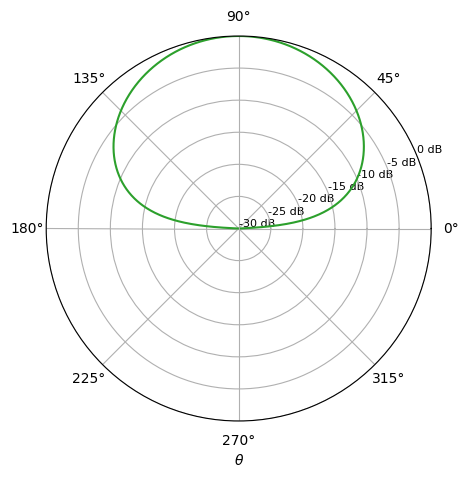

In [13]:
import numpy as np
import matplotlib.pyplot as plt

theta = np.linspace(1e-3, np.pi, 1000)  # Unngå 0 for deling
EF = np.cos((np.pi / 2) * np.cos(theta))  / np.sin(theta)
EF = np.abs(EF)
EF /= np.max(EF)
EF_db = 20 * np.log10(EF + 1e-12)  # i dB

fig = plt.subplots(figsize=(8,5), subplot_kw={'projection': 'polar'})
plt.plot(theta, EF_db, color='tab:green', label="EF")
plt.xlabel(r'$\theta$')
plt.yticks(np.arange(-30, 1, 5),[f'{i} dB' for i in range(-30, 1, 5)],fontsize=8)
plt.ylim(-30, 0)
plt.grid(True)
plt.savefig('Figurer/EF_TM10.pdf', bbox_inches='tight', transparent=True)
plt.show()

# Array Faktor

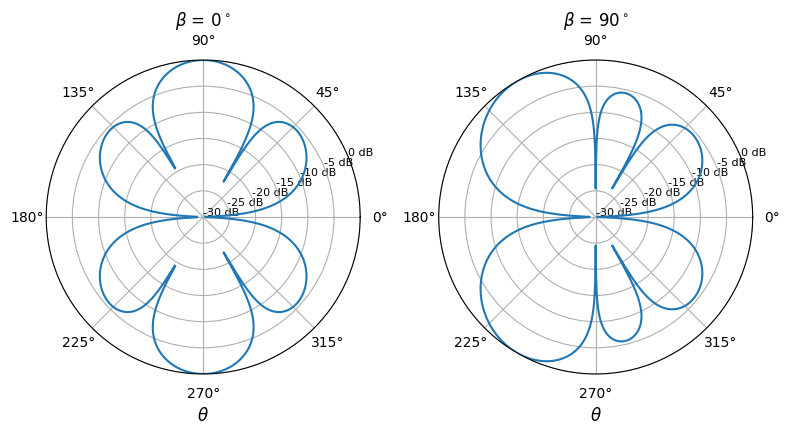

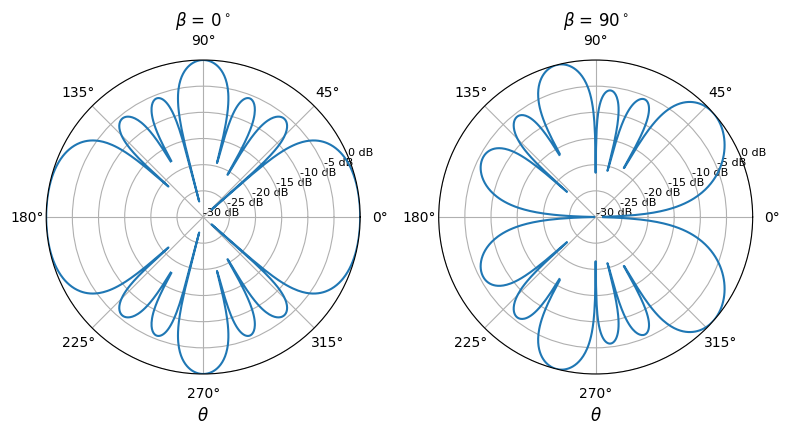

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Konstanter
lambda_ = 1
k = 2 * np.pi / lambda_
theta = np.linspace(0, 2*np.pi, 1000)

# Variabler
N = 4
d_list = np.array([0.5, 1]) * lambda_  # Elementavstander
beta_list = [0, np.pi/2]               # Faseforskyvninger

# Loop over alle d
for d in d_list:
    fig, axs = plt.subplots(1, len(beta_list), subplot_kw={'projection': 'polar'}, figsize=(4 * len(beta_list), 5))

    if len(beta_list) == 1:
        axs = [axs]

    for i, beta in enumerate(beta_list):
        # Arrayfaktor
        psi = k * d * np.cos(theta) + beta
        AF = np.zeros(len(theta), dtype=complex)
        for n in range(N):
            AF += np.exp(1j * n * psi)

        AF = np.abs(AF)
        AF /= np.max(AF)
        AF_db = 10 * np.log10(AF + 1e-100)

        # Plot
        ax = axs[i]
        line1 = ax.plot(theta, AF_db, color='tab:blue')
        ax.set_title(rf'$\beta$ = {np.rad2deg(beta):.0f}$^\circ$')
        ax.set_ylim(-30, 0)
        ax.set_xlabel(r'$\theta$', fontsize=12)
        ax.set_yticks(np.arange(-30, 1, 5))
        ax.set_yticklabels([f'{i} dB' for i in range(-30, 1, 5)],fontsize=8)
        ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'Figurer/AF_d{d/lambda_:.1f}.pdf', bbox_inches='tight',transparent=True)
    plt.show()



# Total Faktor

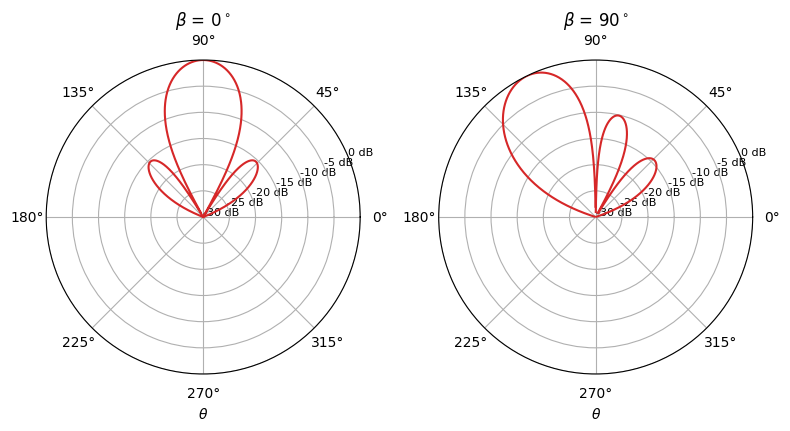

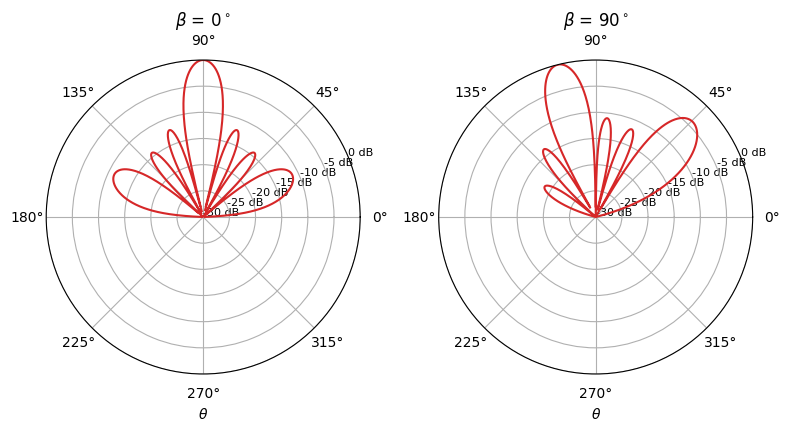

      theta  TF dB (d=0.5, beta=0)  TF dB (d=0.5, beta=90)  \
0  0.001000            -184.182266             -179.653997   
1  0.004144            -147.152611             -142.618813   
2  0.007287            -132.441683             -127.908065   
3  0.010431            -123.096244             -118.562997   
4  0.013575            -116.232045             -111.699309   

   TF dB (d=1.0, beta=0)  TF dB (d=1.0, beta=90)  
0             -62.097948             -174.765748  
1             -49.750094             -137.726689  
2             -44.846372             -123.015163  
3             -41.731178             -113.668949  
4             -39.443055             -106.803716  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Konstanter
lambda_ = 1
k = 2 * np.pi / lambda_
theta = np.linspace(1e-3, np.pi, 1000)  # Unngå deling på null
N = 4

# Variabler
d_list = np.array([0.5, 1]) * lambda_
beta_list = [0, np.pi/2]

# Elementfaktor (E-planet)
EF = np.cos((np.pi / 2) * np.cos(theta)) / np.sin(theta)
EF = np.abs(EF)
EF /= np.max(EF)
EF_db = 20 * np.log10(EF + 1e-12)

TF_data = {}

# Loop over d
for d in d_list:
    fig, axs = plt.subplots(1, len(beta_list), figsize=(4 * len(beta_list), 5), subplot_kw={'projection': 'polar'})

    if len(beta_list) == 1:
        axs = [axs]  # Ensikker itererbarhet

    for i, beta in enumerate(beta_list):
        # Arrayfaktor
        psi = k * d * np.cos(theta) + beta
        AF = np.zeros_like(theta, dtype=complex)
        for n in range(N):
            AF += np.exp(1j * n * psi)
        AF = np.abs(AF)
        AF /= np.max(AF)
        AF_db = 20 * np.log10(AF + 1e-12)

        # Total stråling
        Total = EF * AF
        Total /= np.max(Total)
        Total_db = 20 * np.log10(Total + 1e-12)

        # Lagre dataene i listen
        TF_data['theta'] = theta
        TF_data[f'TF dB (d={d/lambda_:.1f}, beta={np.rad2deg(beta):.0f})'] = Total_db

        # Plot
        ax = axs[i]
        ax.plot(theta, Total_db, color='tab:red')
        ax.set_title(rf'$\beta$ = {np.rad2deg(beta):.0f}$^\circ$')
        ax.set_xlabel(r'$\theta$')
        ax.set_yticks(np.arange(-30, 1, 5))
        ax.set_yticklabels([f'{i} dB' for i in range(-30, 1, 5)],fontsize=8)
        ax.set_ylim(-30, 0)
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(f'Figurer/TF_d{d/lambda_:.1f}.pdf', bbox_inches='tight', transparent=True)
    plt.show()

df_TF = pd.DataFrame(TF_data)

# Lagre DataFrame til en CSV-fil for senere bruk
df_TF.to_csv('df_TF.csv', index=False)

print(df_TF.head())  # Skriv ut de første radene i DataFrame for å sjekke innholdet

Index(['theta', 'TF dB (d=0.5, beta=0)', 'TF dB (d=0.5, beta=90)',
       'TF dB (d=1.0, beta=0)', 'TF dB (d=1.0, beta=90)'],
      dtype='object')


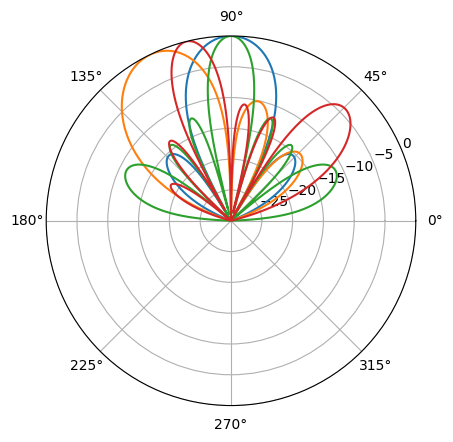

In [10]:
TF_TEST = pd.read_csv('df_TF.csv')
print(TF_TEST.columns)  # Skriv ut de første radene i DataFrame for å sjekke innholdet
fig = plt.subplot(111, polar=True)
for column in TF_TEST.columns[1:]:
    plt.plot(TF_TEST['theta'], TF_TEST[column], label=column)
    plt.ylim(-30, 0)